# Data Leakage in Machine Learning

Data leakage is one of the most critical and costly problems in machine learning. It occurs when information from outside the training dataset is used to create the model, leading to overly optimistic performance estimates. This can result in models that appear to perform exceptionally well during development but fail catastrophically when deployed in real-world scenarios.

In this notebook, we will explore different types of data leakage, understand why they occur, and learn how to prevent them. We'll cover both obvious and subtle forms of data leakage through practical examples and hands-on exercises.

## 1 - Target Leakage (the Most Obvious Form)

The most trivial form of data leakage occurs when **the outcome variable is included in the variables used during the training step**.

In this case, the data leak is obvious. If the outcome variable is present in the training data, the model will achieve perfect performance during training. However, when this model is deployed in production, the problem becomes apparent: the outcome variable is not available (which is why we need a model in the first place), and thus the model will not work at all. 

This is the easiest problem to spot (it results in perfect performance) but causes the most severe issues when missed, as the model simply cannot function without its most important feature.

## 2 - Train-Test Contamination

Train-test contamination is harder to detect because it doesn't necessarily result in perfect performance. This makes it particularly dangerous as results can appear realistic while being overly optimistic. Deploying such models in production can lead to costly failures.

This type of leakage occurs when information from the test set somehow influences the training process, violating the fundamental assumption that training and testing data should be completely independent.

#### Demonstration Setup

To illustrate this problem, we'll create a dataset with:
- 100 rows and 50 columns of random numbers
- A binary outcome variable with 50-50 class balance

**Before we start:** How well do you expect a model trained on random data to perform when predicting other random data? Specifically:
- How should the ROC curve look?
- What should the AUC (Area Under the Curve) value be?

## Demonstration with code

This section demonstrates data leakage through hands-on coding examples. We'll create scenarios that show how different evaluation approaches can lead to misleading results.

In [48]:
import matplotlib.image as img # To load the images
import matplotlib.pyplot as plt # To plot the images
import random
import numpy as np # To do some calculations
import pandas as pd # To work with dataframes (easier matrices)
from sklearn.ensemble import RandomForestClassifier # The machine learning model 

### Creating Synthetic Random Data

We'll create a dataset of completely random numbers to demonstrate how data leakage can make even random data appear predictive. This controlled environment helps us understand the impact of different evaluation strategies.

In [ ]:
random.seed(7)
N_vars =200
N_observations = 2*50
data = pd.DataFrame(np.random.normal(0, 1, (N_observations,N_vars)) )
print(data.shape)
data.head()

(100, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.471389,-1.187320,0.952012,0.320750,0.348200,0.007426,-1.237028,0.991527,-0.361616,0.156083,...,-0.226949,1.607691,-0.874196,0.958630,1.645161,-0.670765,0.017227,-1.322612,-1.056803,0.291627
1,-0.895958,-0.099047,-0.457770,0.009397,-0.393192,-0.857870,-0.239728,0.403655,-1.495266,0.698751,...,-2.127105,-0.801121,0.174273,-1.162211,-0.187787,0.740409,1.245859,-0.865562,-2.074604,0.292491
2,-0.278273,-0.134701,-0.166287,-1.029027,-0.149446,0.595058,-0.433096,-0.373744,-1.792843,0.409247,...,-1.109722,0.282262,-2.082947,-0.140201,2.569545,-0.437261,-0.080122,0.392855,-0.920385,0.256967
3,-1.746446,-1.552618,-0.163324,1.272537,-1.305304,0.318304,0.454183,-0.055415,0.810765,0.425661,...,0.005709,0.585723,-1.437444,0.007430,1.890514,0.963011,0.285150,-0.027102,-1.326236,1.372993
4,-1.527868,-0.550494,-0.216481,-0.356679,0.306829,0.005177,-0.136515,0.372195,0.300274,0.821300,...,-0.878036,-1.394400,2.082152,-0.978657,-0.067742,0.488634,-1.818134,0.290934,0.623050,1.576273


In [ ]:
Outcome_vector = [0,1]*int(N_observations/2)
Outcome_vector[1:20]

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

### 3.1 Training and Evaluating on the Same Data

**Scenario:** Evaluating model performance on the same data used for training.

**Expected Result:** Since we're using completely random data with a random target variable, a properly validated model should perform no better than random chance (AUC ≈ 0.5).

In [24]:
## defining the model
ML_model = RandomForestClassifier()

In [25]:
## Step 2: training the model with the data we prepared

ML_model.fit(data, Outcome_vector)


RandomForestClassifier()

In [26]:
y_prob=ML_model.predict_proba(data)

In [27]:
prediction_check = pd.DataFrame({'True label':Outcome_vector,
                                 'Probability':y_prob[:,1]})
prediction_check

,True label,Probability
0,0,0.18
1,1,0.81
2,0,0.24
3,1,0.90
4,0,0.17
...,...,...
95,1,0.81
96,0,0.19
97,1,0.84
98,0,0.20


In [28]:
TP = sum(np.logical_and(prediction_check['Probability'] >= 0.5, prediction_check['True label'] == 1))
TN = sum(np.logical_and(prediction_check['Probability'] < 0.5, prediction_check['True label'] == 0))
FP = sum(np.logical_and(prediction_check['Probability'] >= 0.5, prediction_check['True label'] == 0))
FN = sum(np.logical_and(prediction_check['Probability'] < 0.5, prediction_check['True label'] == 1))

In [29]:
print(TP)
print(TN)
print(FP)
print(FN)

50
50
0
0


In [30]:
sensitivity_recall = TP /(TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

print("sensitivity/recall = " + str(100*sensitivity_recall)+ "%")
print("specificity = " + str(100*specificity)+ "%")
print("precision = " + str(100*precision)+ "%")

sensitivity/recall = 100.0%
specificity = 100.0%
precision = 100.0%


##### 📊 Analysis Question 1: Training Data Evaluation

**What can you conclude from the confusion matrix, precision, and specificity results?**

*Consider:*
- Are these results realistic for random data?
- What does perfect performance on training data tell us?
- Why might this be misleading for real-world deployment?

**Expected Answer:**
The model shows perfect or near-perfect performance on the training data, which is impossible with truly random data. This demonstrates overfitting - the model has memorized the training examples rather than learning generalizable patterns. This is why we need proper train-test splits.

In [31]:
Thresholds = np.arange(0.01, 1,0.01)
Thresholds        

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

#### ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate against the False Positive Rate at various threshold settings. For random data, we expect the curve to follow the diagonal line (AUC = 0.5).

In [32]:
from sklearn import metrics
fpr_training, tpr_training, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

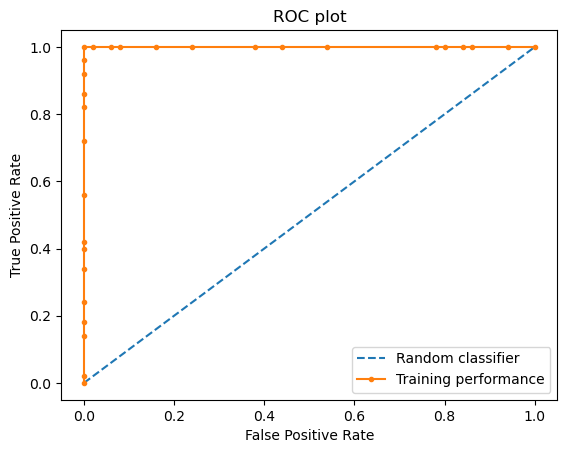

In [33]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_training, tpr_training, marker='.', label='Training performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### 📊 Analysis Question 2: ROC Curve Interpretation

**What does the ROC curve tell you?**

*Consider:*
- How does the training performance compare to the random classifier line?
- What would you expect for truly random data?
- What does this suggest about model evaluation practices?

**Expected Answer:**
The training performance ROC curve shows much better than random performance (AUC >> 0.5), which is impossible with truly random data. This demonstrates that evaluating on training data gives misleadingly optimistic results due to overfitting.

### 3.2 Proper Train-Test Split Comparison

Now we'll demonstrate the correct approach: training on one subset of data and evaluating on a completely separate subset that the model has never seen.

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    Outcome_vector, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [36]:
## Step 1: defining the model
ML_model = RandomForestClassifier()

## Step 2: training the model with the data we prepared
ML_model.fit(X_train, y_train)

## Step 3: evaluation
y_prob=ML_model.predict_proba(X_test)

prediction_check = pd.DataFrame({'True label':y_test,
                                'Probability': y_prob[:,1]})


fpr_test, tpr_test, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

prediction_check


,True label,Probability
0,1,0.56
1,1,0.37
2,0,0.43
3,1,0.49
4,0,0.37
5,1,0.68
6,0,0.48
7,0,0.42
8,0,0.46
9,0,0.57


### 3.3 Comparison with cross validation

In [37]:
from sklearn.model_selection import KFold

In [38]:
k = 10
kf = KFold(n_splits=k)
ML_model = RandomForestClassifier()


Cross_val_list = []

 
for train_index , test_index in kf.split(data):
    X_train , X_test = data.iloc[train_index,:],data.iloc[test_index,:]
    y_train , y_test = np.take(Outcome_vector, train_index) == 1 , np.take(Outcome_vector, test_index) == 1
     
    ML_model.fit(X_train,y_train)
    
    y_prob = ML_model.predict_proba(X_test)
    

    Cross_val_list.append(
        pd.DataFrame({
            'True label': y_test,
            'Probability':  y_prob[:,1]
        })
    )

Cross_val_results = pd.concat(Cross_val_list)
fpr_CV, tpr_CV, thresh = metrics.roc_curve(Cross_val_results['True label'] == 1, Cross_val_results['Probability'])

Cross_val_results

,True label,Probability
0,False,0.59
1,True,0.49
2,False,0.60
3,True,0.61
4,False,0.32
...,...,...
5,True,0.40
6,False,0.61
7,True,0.58
8,False,0.56


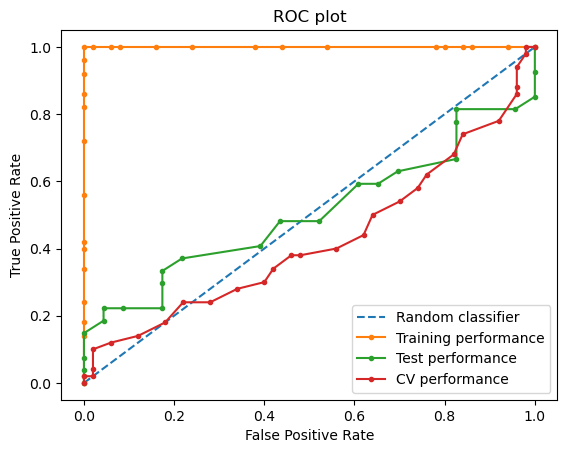

In [39]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_training, tpr_training, marker='.', label='Training performance')
plt.plot(fpr_test, tpr_test, marker='.', label='Test performance')
plt.plot(fpr_CV, tpr_CV, marker='.', label='CV performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### 📊 Analysis Question 3: Comparing Evaluation Methods

**What does the comparison of ROC curves tell you?**

*Compare the different lines:*
- Training performance vs. Test performance vs. Cross-validation performance
- Which one represents the most realistic estimate of real-world performance?
- Why do you think there are differences between these methods?

**Expected Answer:**
- **Training performance:** Overly optimistic due to overfitting
- **Test performance:** More realistic, closer to random (AUC ≈ 0.5) as expected for random data  
- **Cross-validation performance:** Most reliable estimate, averages across multiple train-test splits

The test and CV performances show that the model performs no better than random chance on unseen data, which is the correct result for random input features.

### 3.4 Preprocessing Leakage in Feature Selection

This section examines the most subtle form of data leakage: preprocessing leakage caused by improper feature selection and data preprocessing.

This form of data leakage is the most difficult to detect and therefore the most common in practice. It doesn't result in perfect performance, making it appear realistic while still being overly optimistic.

**The Problem:** It's not sufficient to simply train your model on part of the data and evaluate on another part. **All preprocessing steps must be based exclusively on the training data.**

**Common Mistake:** Performing feature selection, normalization, or other preprocessing on the entire dataset before splitting into train/test sets.

**Why This Matters:** Any preprocessing that uses information from the test set can leak information about test set patterns into the training process, leading to overly optimistic performance estimates.

Let's demonstrate this by adding a feature selection step that commits this error.

In [ ]:
from sklearn.feature_selection import SelectKBest
selectR = SelectKBest(k=5)
data_selected = selectR.fit_transform(data, Outcome_vector)

In [ ]:
selectR.get_support(indices=True)

array([ 39,  69,  87, 153, 169])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    Outcome_vector, 
                                                    test_size=0.5,
                                                    random_state=42)


In [ ]:
selectR = SelectKBest(k=5)
X_train_selected = selectR.fit_transform(X_train, y_train)
X_train_selected.shape

(50, 5)

In [ ]:
selected_columns = selectR.get_support(indices=True)
selected_columns

array([ 55,  65,  91, 106, 198])

In [ ]:
X_test = X_test.iloc[:,selected_columns]
X_test.shape

(50, 5)

In [ ]:
from sklearn import metrics

## Step 1: defining the model
ML_model = RandomForestClassifier()

## Step 2: training the model with the data we prepared
ML_model.fit(X_train_selected, y_train)

## Step 3: evaluation
y_prob=ML_model.predict_proba(X_test)

prediction_check = pd.DataFrame({'True label':y_test,
                                'Probability': y_prob[:,1]})


fpr_test_feat_sel, tpr_test_feat_sel, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

prediction_check

,True label,Probability
0,1,0.58
1,1,0.55
2,0,0.24
3,1,0.50
4,0,0.37
5,1,0.30
6,0,0.45
7,0,0.75
8,0,0.43
9,0,0.59


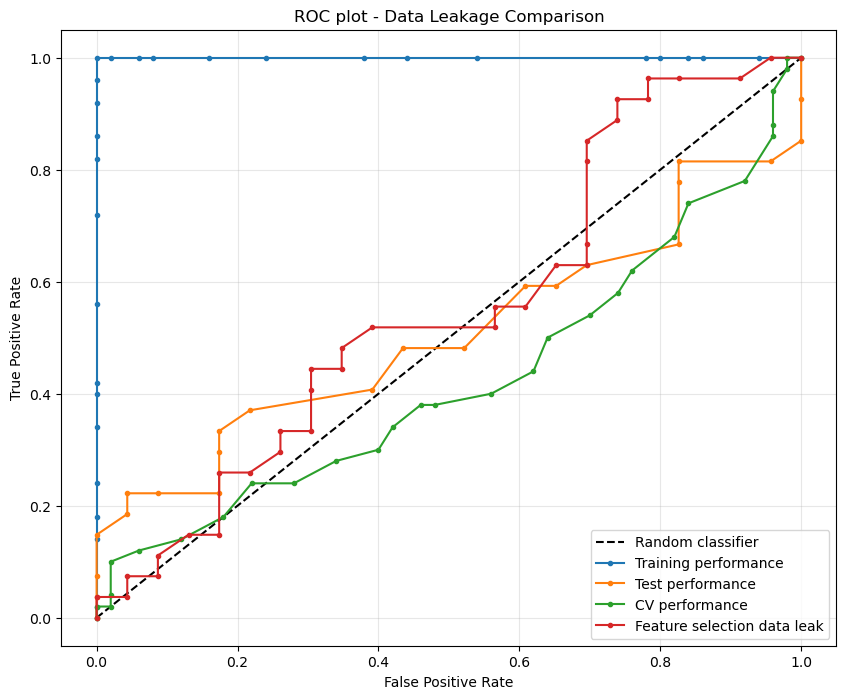

In [ ]:
# Check which variables are available and plot accordingly
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier', color='black')

# Only plot if variables exist in the current namespace
try:
    plt.plot(fpr_training, tpr_training, marker='.', label='Training performance')
except NameError:
    print("Training performance data not available - run earlier cells first")

try:
    plt.plot(fpr_test, tpr_test, marker='.', label='Test performance')
except NameError:
    print("Test performance data not available - run earlier cells first")

try:
    plt.plot(fpr_CV, tpr_CV, marker='.', label='CV performance')
except NameError:
    print("Cross-validation performance data not available - run earlier cells first")

# This should be available from the feature selection section
try:
    plt.plot(fpr_test_feat_sel, tpr_test_feat_sel, marker='.', label='Feature selection data leak')
except NameError:
    print("Feature selection data not available - run feature selection cells first")

plt.title('ROC plot - Data Leakage Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#### 📊 Analysis Question 4: Feature Selection Data Leakage

**What does the ROC curve tell you about the feature selection approach?**

*Compare the "Feature selection data leak" line with the proper evaluation methods:*
- How does it compare to the proper train-test split?
- Why might feature selection on the entire dataset create overly optimistic results?
- What's the correct way to perform feature selection?

**Key Insight:** The feature selection process had access to the test set outcomes when selecting features, creating a subtle form of data leakage that makes the model appear more successful than it actually is.

**Expected Answer:**

The feature selection approach shows better performance than the proper train-test split because:

1. **Information Leakage:** Feature selection was performed on the entire dataset (including test data) before splitting
2. **Biased Selection:** Features were chosen based on their correlation with the entire outcome vector, including future test cases
3. **Overly Optimistic Results:** This makes the model appear more predictive than it would be in real deployment

**Correct Approach:**
- Split data into train/test sets first
- Perform feature selection only on training data
- Apply the same feature selection results to test data
- This ensures no information from test set influences the training process

**Real-World Impact:** This subtle form of leakage is extremely common and can lead to models that fail dramatically when deployed, despite appearing successful during development.

## Brainstorming Examples

This section contains practical exercises to help you identify and understand different types of data leakage in real-world scenarios.

### Exercise 1: Preventing Healthcare Infections

**Scenario:**
A healthcare agency wants to predict which patients undergoing a rare surgery are at risk of infection. This would allow nurses to provide extra care and monitoring for high-risk patients.

**Your Approach:**
You decide to build a predictive model where:
- Each row represents a single patient who received the surgery
- The target variable is whether the patient developed an infection
- You want to incorporate surgeon information, as different surgeons may have varying infection rates

**Your Clever Idea:**
1. Calculate the infection rate for each surgeon based on all their past surgeries
2. For each patient in your dataset, identify their surgeon
3. Use that surgeon's historical infection rate as a feature in your model

**Questions to Consider:**
- Does this approach pose any target leakage issues? 
- Does it pose any train-test contamination issues?
- What problems might arise when deploying this model in production?

#### Answer Exercise 1:

**Analysis:** This approach contains **train-test contamination**. Here's why:

When calculating each surgeon's infection rate, you're using data from the entire dataset, including patients who should be in your test set. This means information about test set outcomes (infections) is being used to create features for training.

**The Problem:**
- In production, you wouldn't have access to future patient outcomes to calculate surgeon infection rates
- The historical infection rate should only be calculated using data available before the prediction is made
- This creates an unrealistically optimistic performance estimate

**Better Approach:**
Calculate surgeon infection rates using only historical data that was available before each patient's surgery date.

### Exercise 2: Cryptocurrency Price Prediction

**Scenario:**
Your data scientist friend claims to have built a model that predicts cryptocurrency prices one day ahead with remarkable accuracy. He wants you to invest money based on his model's predictions.

**Model Details:**
- **Prediction target:** Next day's cryptocurrency price
- **Performance:** Average error less than $1, despite price fluctuations over $100
- **Strategy:** Buy when model predicts price increase

**Key Features:**
1. Current price of the currency
2. Amount of currency sold in the last 24 hours  
3. Change in currency price in the last 24 hours
4. Change in currency price in the last 1 hour
5. Number of new tweets mentioning the currency in the last 24 hours

**Critical Question:**
Your friend argues that such low error proves the model's accuracy and profitability. Is he right? If there's a problem with his model, what is it?

**Think About:**
- Which features might be problematic for predicting *tomorrow's* price?
- What information would be available at the time of making a prediction?
- How might this affect real-world performance?

#### Answer Exercise 2:

**Analysis:** This model suffers from **temporal data leakage**.

**The Problem:**
When predicting tomorrow's price, features like "change in price in the last 24 hours" and "change in price in the last 1 hour" include information from periods that overlap with or are very close to the prediction target.

**Specific Issues:**
- If predicting Tuesday's closing price on Monday, "last 24 hours of price changes" includes information very close to the prediction time
- The model may be learning from price movements that are essentially part of what it's trying to predict
- High-frequency price changes often show strong autocorrelation, making recent changes highly predictive of immediate future changes

**Why It Seems Accurate:**
The model achieves low error because it's essentially predicting based on very recent price movements, which are naturally correlated with near-future prices. However, this doesn't represent genuine predictive power for investment purposes.

**Real-World Reality:**
In actual trading, by the time you receive the prediction and place orders, the market conditions that generated the prediction have likely changed, making the prediction much less reliable.